In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import pylab
import pickle
import warnings
from xgboost import XGBClassifier

from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency 
import sklearn.metrics as mt

**EXPLATORY RAW DATA ANALYSIS**

In [3]:
df = None

def read_csv_file(file_path):
    global df 
    df = pd.read_csv(file_path)

def print_dataframe_info(df):
    print(df.info())
    print('------------------')
    print(df.head())
    print('------------------')
    print(df.describe())
    print('------------------')
    print(df.isnull().sum())
    print('------------------')

def main():
    file_path = 'loan_approval_dataset.csv'
    read_csv_file(file_path) 
    print_dataframe_info(df)

if __name__ == '__main__':
    main()

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None
----------

In [4]:
# Since there were spaces at the beginning and end of the column and row names in the data set, the spaces were deleted for processing.
df.columns = df.columns.str.strip()

# Delete leading and trailing spaces on all lines
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.drop(columns='loan_id')


In [5]:
df_proc = df.copy()
cat_cols=['education', 'self_employed', 'loan_status']
for i in cat_cols:
    print(i)
    print('df:',sorted(df_proc[i].unique()))
    
    # categorical variable transformation OHE, and since the category is less than 15
ohe = OneHotEncoder(handle_unknown = 'ignore')
load_df_encoded = ohe.fit_transform(df_proc[cat_cols]).toarray()

df_encoded = pd.get_dummies(df_proc, columns=['education', 'self_employed', 'loan_status'], dtype='int64')

education
df: ['Graduate', 'Not Graduate']
self_employed
df: ['No', 'Yes']
loan_status
df: ['Approved', 'Rejected']


In [6]:
label_encoder = LabelEncoder()

for column in df_proc.columns:
    if df_proc[column].dtype == 'object':
        df_proc[column] = label_encoder.fit_transform(df_proc[column])

In [7]:
# There is no imbalance in the education and self-employed columns, but there is an imbalance in the credit case
print(df_proc['education'].value_counts())
print(df_proc['self_employed'].value_counts())
print(df_proc['loan_status'].value_counts())
# we look dependet variable situation balance
print(df_proc.loan_status.value_counts()/df_proc.shape[0]*100,2)

education
0    2144
1    2125
Name: count, dtype: int64
self_employed
1    2150
0    2119
Name: count, dtype: int64
loan_status
0    2656
1    1613
Name: count, dtype: int64
loan_status
0    62.215976
1    37.784024
Name: count, dtype: float64 2


array([[<Axes: title={'center': 'no_of_dependents'}>,
        <Axes: title={'center': 'education'}>,
        <Axes: title={'center': 'self_employed'}>],
       [<Axes: title={'center': 'income_annum'}>,
        <Axes: title={'center': 'loan_amount'}>,
        <Axes: title={'center': 'loan_term'}>],
       [<Axes: title={'center': 'cibil_score'}>,
        <Axes: title={'center': 'residential_assets_value'}>,
        <Axes: title={'center': 'commercial_assets_value'}>],
       [<Axes: title={'center': 'luxury_assets_value'}>,
        <Axes: title={'center': 'bank_asset_value'}>, <Axes: >]],
      dtype=object)

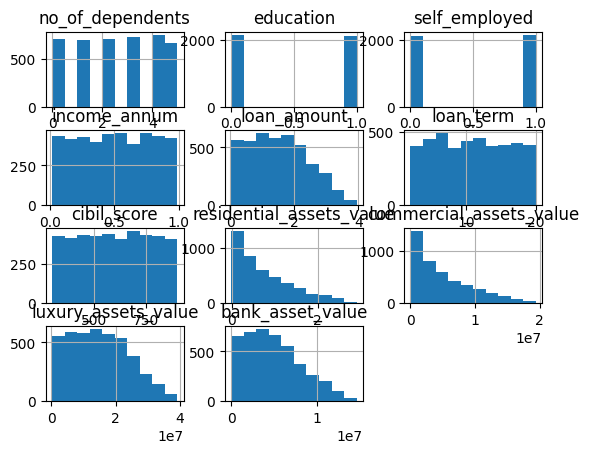

In [8]:
X = df_proc.drop(columns='loan_status')
y = df_proc['loan_status']
X.hist()
# If the histogram is interpreted, an exponential distribution is observed in the 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value' variables.

**For Unprocessing Data Model Prediciton**

In [9]:
# First of all, the success of the model is evaluated in its raw form without transforming the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.value_counts())
#Dependent variable is balanced

(2988, 11) (1281, 11) (2988,) (1281,)
loan_status
0    1846
1    1142
Name: count, dtype: int64


**Logistic Regression Model**

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)
# In other words, the correct classification rate f1 - score is around 63%, representing a low accuracy.
# 810 examples, where the model correctly declined credit applications 
# The success rate of those whose credit approval was accepted was poor and was obtained as 0.40.
# recall: detection of those who need real credit is very low 0.01.


Model Accuracy: 0.629976580796253
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.99      0.77       810
           1       0.40      0.01      0.02       471

    accuracy                           0.63      1281
   macro avg       0.52      0.50      0.40      1281
weighted avg       0.55      0.63      0.50      1281



**PREPROCESSED DATA SET ANALYSIS**

Chi2 Analysis for Categorical Variables

In [17]:
df_norm = df.copy()
chisqt = pd.crosstab(df_norm.education, df_norm.self_employed, margins=True)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
p_value = chi2_contingency(value)[0]
print(f'p-value:{p_value}')
alpha = 0.05  # Anlamlılık seviyesi
if p_value < alpha:
    print("İki değişken arasında anlamlı bir ilişki vardır.")
else:
    print("İki değişken arasında anlamlı bir ilişki yoktur.")


p-value:2.3024245418855758
İki değişken arasında anlamlı bir ilişki yoktur.


P Values:
[[0.00000000e+000 6.35025242e-001 9.43701961e-001 1.84496940e-001
  5.09576904e-001 4.46885754e-001 7.96438012e-001 7.54031944e-001
  3.90491021e-001]
 [6.35025242e-001 0.00000000e+000 0.00000000e+000 4.53643425e-001
  1.33486043e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [9.43701961e-001 0.00000000e+000 0.00000000e+000 4.48734481e-001
  1.91263869e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [1.84496940e-001 4.53643425e-001 4.48734481e-001 0.00000000e+000
  6.02225756e-001 8.61432661e-001 9.41951916e-001 5.79104896e-001
  3.46420291e-001]
 [5.09576904e-001 1.33486043e-001 1.91263869e-001 6.02225756e-001
  0.00000000e+000 4.17293080e-002 9.24356060e-001 5.21507747e-002
  1.95984265e-001]
 [4.46885754e-001 0.00000000e+000 0.00000000e+000 8.61432661e-001
  4.17293080e-002 0.00000000e+000 2.71724930e-210 0.00000000e+000
  0.00000000e+000]
 [7.96438012e-001 0.00000000e+000 0.00000000e+000 9.41951916e-001
  9.24356060e-001 

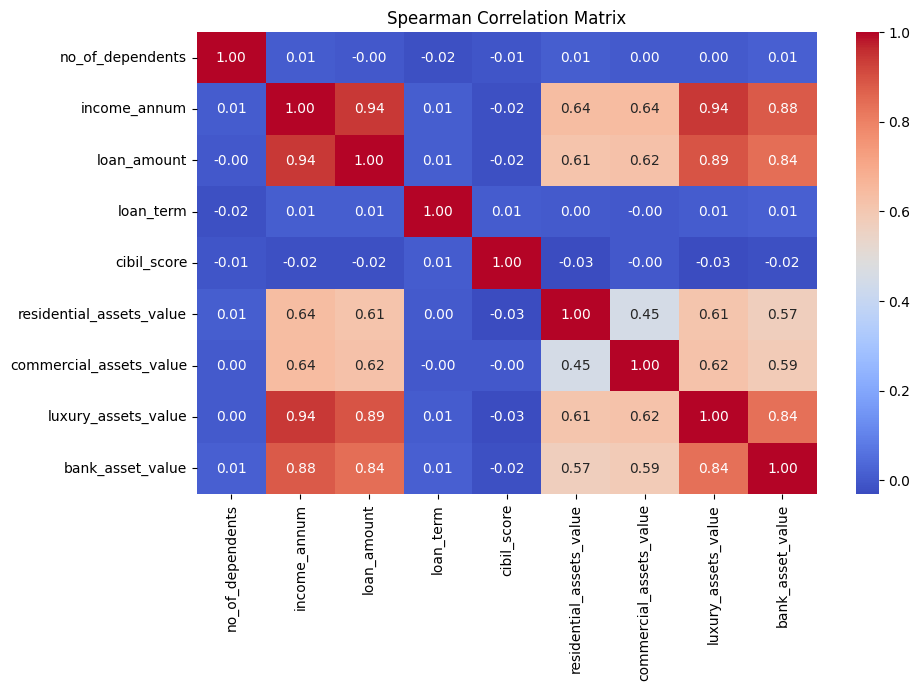

In [18]:
continous_variables = df_norm.select_dtypes(include=['int64'])

variable_names = continous_variables.columns

correlation_matrix, p_values = spearmanr(continous_variables, nan_policy='omit')

correlation_df = pd.DataFrame(correlation_matrix, columns=variable_names, index=variable_names)

print("P Values:")
print(p_values)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

In [19]:
# There is a strong relationship between income_annum and loan amount but this relationship can cause to multicolinearity problem. It can be look.
# There is a strong relationship between income_annum and blank asset value
# There is a strong relationship between lank asset value and luxury asset value.

**Transfrorm Variables**

array([[<Axes: title={'center': 'no_of_dependents'}>,
        <Axes: title={'center': 'income_annum'}>,
        <Axes: title={'center': 'loan_amount'}>],
       [<Axes: title={'center': 'loan_term'}>,
        <Axes: title={'center': 'cibil_score'}>,
        <Axes: title={'center': 'residential_assets_value'}>],
       [<Axes: title={'center': 'commercial_assets_value'}>,
        <Axes: title={'center': 'luxury_assets_value'}>,
        <Axes: title={'center': 'bank_asset_value'}>]], dtype=object)

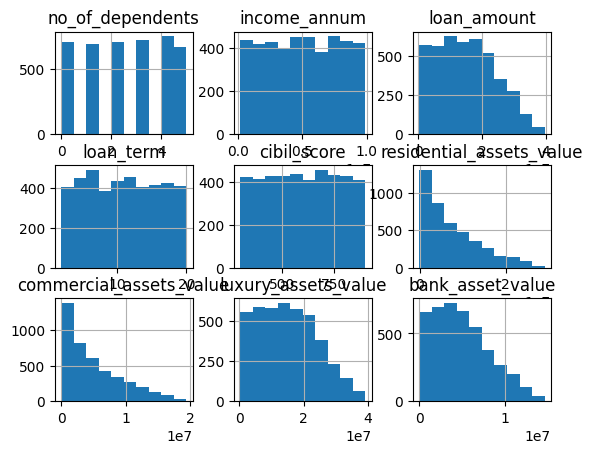

In [20]:
df_norm.hist()
# There is an exponential distribution in the variables commercial_assets_value, luxury_assets_value, bank_assets_value, so boxplot transformation should be applied.
# Although the residental_assets_value variable looks like an exponential distribution, it cannot be applied because it has negative values.

<Axes: >

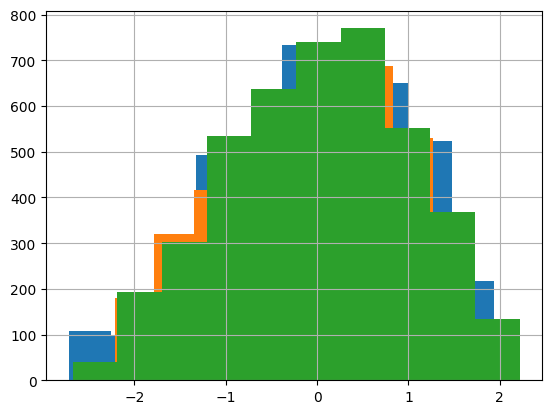

In [21]:
df_st = df_norm.copy()

pt = preprocessing.PowerTransformer(method='box-cox')
df_st['commercial_assets_value'] = pt.fit_transform(df_st['commercial_assets_value'].to_numpy().reshape(-1, 1)+0.001)
df_st['commercial_assets_value'].hist()

pt = preprocessing.PowerTransformer(method='box-cox')
df_st['luxury_assets_value'] = pt.fit_transform(df_st['luxury_assets_value'].to_numpy().reshape(-1, 1)+0.001)
df_st['luxury_assets_value'].hist()

pt = preprocessing.PowerTransformer(method='box-cox')
df_st['bank_asset_value'] = pt.fit_transform(df_st['bank_asset_value'].to_numpy().reshape(-1, 1)+0.001)
df_st['bank_asset_value'].hist()

**Encoding Processing**

In [22]:
cat_cols=['education', 'self_employed', 'loan_status']

for i in cat_cols:
    print(i)
    print('df:',sorted(df_st[i].unique()))
    
    # categorical variable transformation OHE, and since the category is less than 15
ohe = OneHotEncoder(handle_unknown = 'ignore')
load_df_encoded = ohe.fit_transform(df_st[cat_cols]).toarray()

df_encoded = pd.get_dummies(df_st, columns=['education', 'self_employed', 'loan_status'], dtype='int64')
df_encoded

education
df: ['Graduate', 'Not Graduate']
self_employed
df: ['No', 'Yes']
loan_status
df: ['Approved', 'Rejected']


,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,education_Graduate,education_Not Graduate,self_employed_No,self_employed_Yes,loan_status_Approved,loan_status_Rejected
0,2,9600000,29900000,12,778,2400000,1.803615,0.853329,0.942285,1,0,1,0,1,0
1,0,4100000,12200000,8,417,2700000,-0.345579,-0.585799,-0.343677,0,1,0,1,0,1
2,3,9100000,29700000,20,506,7100000,0.244211,1.711457,1.891947,1,0,1,0,0,1
3,3,8200000,30700000,8,467,18200000,-0.027521,0.905697,0.919785,1,0,1,0,0,1
4,5,9800000,24200000,20,382,12400000,0.850148,1.410576,0.190028,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,1000000,2300000,12,317,2800000,-1.220339,-1.421371,-1.521101,1,0,0,1,0,1
4265,0,3300000,11300000,20,559,4200000,-0.133246,-0.316613,-0.902304,0,1,0,1,1,0
4266,2,6500000,23900000,18,457,1200000,1.338372,0.431648,0.781663,0,1,1,0,0,1
4267,1,4100000,12800000,8,780,8200000,-1.055339,0.028504,0.408931,0,1,1,0,1,0


In [23]:
label_encoder = LabelEncoder()

for column in df_st.columns:
    if df_st[column].dtype == 'object':
        df_st[column] = label_encoder.fit_transform(df_st[column])

In [24]:
X = df_st.drop(columns='loan_status')
y = df_st['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.value_counts())

**Best Model Choosing**

**Logistic Regression Model**

In [32]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

y_pred = model_log.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

class_report_final = classification_report(y_test, y_pred)
print("Classification Report Final:\n", class_report_final)
# In other words, the correct classification rate f1 - score is around 63%, representing a low accuracy.
# 810 examples, where the model correctly declined credit applications 
# The success rate of those whose credit approval was accepted was poor and was obtained as 0.40.
# recall: detection of those who need real credit is very low 0.01.
### Outlier values in the data set are at normal levels. These values are not at a level that will disrupt the data set, as can be seen from the fact that the min, max and median values are not extreme. 

Model Accuracy: 0.7306791569086651
Classification Report Final:
               precision    recall  f1-score   support

           0       0.72      0.94      0.81       536
           1       0.79      0.38      0.51       318

    accuracy                           0.73       854
   macro avg       0.75      0.66      0.66       854
weighted avg       0.74      0.73      0.70       854



**XGBoost Classifier Model**

In [36]:
# In my previous studies, hyperparameters were generally tried that would give the best parameter.
xgb_model = XGBClassifier(
                 learning_rate =0.1 ,
                 max_depth = 5 ,
                 min_samples_split = 2,
                 n_estimators = 500,
                 scale_pos_weight = 10,
                 subsample =0.8,
)

xgb_model.fit(X_train,y_train)

/Users/sibelyilmaz/Desktop/koc2/pred_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:04:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [45]:
y_pred = xgb_model.predict(X_test)
print("Confussion Matrix: \n", mt.confusion_matrix(y_test, y_pred))
TN, FP, FN, TP = mt.confusion_matrix(y_test, y_pred).ravel()
print(f"\nTN {TN}, FP {FP}, FN {FN}, TP {TP}")
print("\nclassification report \n" ,mt.classification_report(y_test, y_pred))

Confussion Matrix: 
 [[524  12]
 [  4 314]]

TN 524, FP 12, FN 4, TP 314

classification report 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       536
           1       0.96      0.99      0.98       318

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [27]:
### When the test size is taken as 0.2 and the conversion is applied, 
# The accuracy becomes 0.81. And when education data is included more, 
# The determination of granting or not granting credit is estimated 81 percent accurately in the data set 
# That includes the education level and development assets values.

**Write File for Model**

In [28]:
with open('class_report_final.pkl', 'wb') as file:
    pickle.dump(class_report_final, file)